Dependencies and packages

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [92]:
def check_graph(nxgraph):
    # Check if the graph has any nodes.
    print("Graph nodes:")
    if nxgraph.number_of_nodes() > 0:
        print("The graph has nodes.")
        #count number of nodes
        print("Number of nodes:", nxgraph.number_of_nodes())
    else:
        print("The graph does not have any nodes.")
    # Check if the graph has any edges.
    print("\nGraph edges:")
    if nxgraph.number_of_edges() > 0:
        print("The graph has edges.")
        #count number of edges
        print("Number of edges:", nxgraph.number_of_edges())
    else:
        print("The graph does not have any edges.")
    # Check if the graph is connected.
    print("\nGraph connection:")
    if nx.is_connected(nxgraph):
        print("The graph is connected.")
    else:
        print("The graph is disconnected.")

Import Data

In [2]:
ddb = gpd.read_file('./data/ddb_roundabout.geojson')

In [7]:
ddb.describe()

,xacc,yacc,speed,maxspeed,lanecount,index_right,distances
count,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,-0.200092,0.295709,37.199354,49.127365,1.584218,374.650669,8.001034
std,0.320146,0.464281,15.537877,14.110415,0.505912,274.480741,16.428204
min,-1.962000,-1.096000,0.000000,21.000000,1.000000,4.000000,0.000139
25%,-0.393500,-0.014000,29.000000,40.000000,1.000000,99.000000,0.089520
50%,-0.143000,0.595000,38.000000,47.000000,2.000000,331.000000,0.487405
75%,0.046500,0.637000,46.000000,57.000000,2.000000,624.000000,8.803115
max,1.116000,0.957000,97.000000,106.000000,3.000000,903.000000,98.211709


In [3]:
accident = gpd.read_file('./data/crash_roundabout.geojson')

In [8]:
accident.describe()

,LONGITUDE,LATITUDE,index_right,distances
count,10047.000000,10047.000000,10047.000000,10047.000000
mean,149.114135,-35.313833,418.502837,23.140083
std,0.036091,0.083786,267.615589,25.819755
min,149.001891,-35.473487,1.000000,0.000000
25%,149.091316,-35.402737,131.000000,4.734190
50%,149.111922,-35.303029,492.000000,12.470328
75%,149.139859,-35.257342,651.000000,31.502211
max,149.381421,-35.149008,903.000000,99.975227


In [15]:
roundabout = gpd.read_file('./data/roundabout-v2.geojson')

In [16]:
roundabout

,geometry
0,"POLYGON ((149.02752 -35.20240, 149.02752 -35.2..."
1,"POLYGON ((149.03340 -35.20588, 149.03338 -35.2..."
2,"POLYGON ((149.02890 -35.19941, 149.02891 -35.1..."
3,"POLYGON ((149.02712 -35.20537, 149.02708 -35.2..."
4,"LINESTRING (149.16504 -35.22496, 149.16497 -35..."
...,...
899,"LINESTRING (149.14601 -35.24354, 149.14602 -35..."
900,"LINESTRING (149.14610 -35.24351, 149.14610 -35..."
901,"LINESTRING (149.08657 -35.33668, 149.08649 -35..."
902,"LINESTRING (149.15659 -35.20972, 149.15668 -35..."


In [17]:
roundabout.describe()

,geometry
count,904
unique,904
top,"POLYGON ((149.0275191 -35.2024024, 149.0275175..."
freq,1


In [22]:
roundabout['geometry'].type.unique()

array(['Polygon', 'LineString'], dtype=object)

Method:

The goal is to create a graph similar to version 1 but with lesser edges and lesser nodes for a clearer defined graph

1. original way was to add nodes based on rows in ddb dataset
2. change to cluster rows in ddb dataset based on location dataset
    - cluster similar ddb rows in ddb dataset that are within a specific location
3. save respective x acc, y acc, and classification to the clustered rows of ddb so that it can be used to connect edges later
4. create empty graph
5. add nodes based on clustered rows (location) dataset
6. add edges based on behaviour relationship using the saved features (xacc, yacc, classification)

Step 1:

In [26]:
# Convert the roundabout coordinates to a NumPy array
def get_coordinates(geom):
    if geom.type == 'Polygon':
        return list(geom.exterior.coords)
    else:
        return list(geom.coords)


roundabout_coordinates = np.array(roundabout.geometry.apply(get_coordinates))

C:\Users\User\AppData\Local\Temp\ipykernel_29380\1003535436.py:3: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Polygon':


In [28]:
len(roundabout_coordinates)

904

In [40]:
# Convert the ddb coordinates to a NumPy array
ddb_coordinates = np.array(np.array([[point.x, point.y] for point in ddb['geometry']]))

In [41]:
len(ddb_coordinates)

2167

In [65]:
ddb_coordinates.shape

(2167, 2)

In [36]:
ddb_coordinates

array([list([16595825.834815076, -4208110.694462051]),
       list([16597539.709695332, -4206559.2101193825]),
       list([16597539.709695332, -4206559.2101193825]), ...,
       list([16605925.406936785, -4207808.075128805]),
       list([16606322.594879936, -4208557.816760168]),
       list([16605921.176796138, -4207828.813429508])], dtype=object)

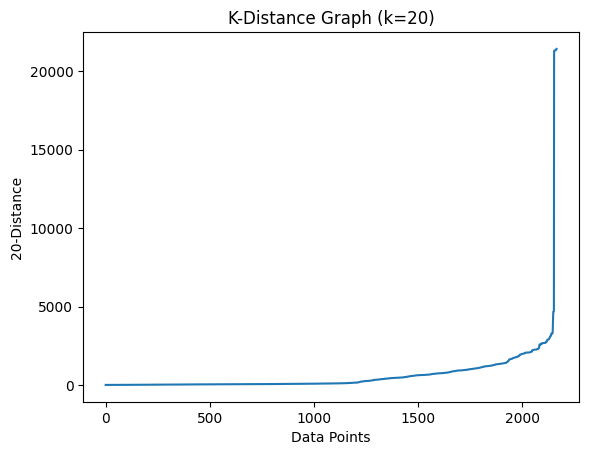

In [77]:
# Calculate the distance to the k-th nearest neighbor for each data point
k = 20
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(ddb_coordinates)
distances, indices = neigh.kneighbors()

# Sort the distances and plot them
distances = np.sort(distances[:, k-1])

# Plot the K-distance graph
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Graph (k={k})')
plt.show()


In [90]:
# Set up the DBSCAN clustering

# value set based on k-distance graph curve
epsilon = 3500

# value set based on k-distance graph and desired cluster size/density
min_samples = 20

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(ddb_coordinates)
cluster_labels = dbscan.fit_predict(ddb_coordinates)

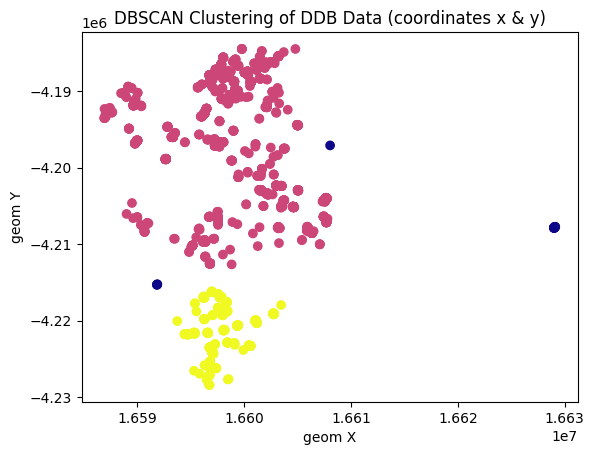

In [91]:
"""
https://www.section.io/engineering-education/dbscan-clustering-in-python/
"""
#Plot DBSCAN clustering of clusters
plt.scatter(ddb_coordinates[:, 0], ddb_coordinates[:, 1], c=cluster_labels, cmap="plasma")
plt.xlabel("geom X")
plt.ylabel("geom Y")
plt.title('DBSCAN Clustering of DDB Data (coordinates x & y)')
plt.show()

In [51]:
# Cluster the DDB data based on their proximity to Location points
ddb['ddb_cluster'] = dbscan.fit_predict(ddb_coordinates)

In [53]:
# Group or cluster features within the location clusters
ddb['mean_x_acc'] = ddb.groupby('ddb_cluster')['xacc'].transform('mean')

ddb['mean_y_acc'] = ddb.groupby('ddb_cluster')['yacc'].transform('mean')

ddb['mean_classification'] = ddb.groupby('ddb_cluster')['classification'].transform('mean')

TypeError: Could not convert BrakingBrakingBrakingSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingBrakingSteeringBrakingBrakingSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingBrakingSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingBrakingBrakingBrakingBrakingSteeringBrakingBrakingSteeringBrakingBrakingSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingSteeringBrakingBrakingSteeringSteeringBrakingBrakingBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingBrakingBrakingBrakingBrakingSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingBrakingSteeringBrakingBrakingSteeringBrakingSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingSteeringBrakingBrakingSteeringBrakingBrakingSteeringBrakingBrakingSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringBrakingSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringBrakingBrakingSteeringBrakingBrakingSteeringBrakingSteeringSteeringBrakingBrakingSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringBrakingBrakingBrakingSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringBrakingBrakingBrakingSteeringBrakingBrakingBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingBrakingBrakingBrakingBrakingBrakingBrakingSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringBrakingSteeringBrakingBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringBrakingSteeringBrakingBrakingSteeringBrakingBrakingBrakingBrakingBrakingBrakingBrakingBrakingSteeringBrakingBrakingBrakingBrakingSteeringSteeringBrakingBrakingSteeringSteeringBrakingBrakingSteeringSteeringBrakingBrakingSteeringSteeringSteeringSteeringSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringSteeringSteeringBrakingBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringBrakingBrakingBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringBrakingBrakingSteeringBrakingBrakingBrakingSteeringBrakingBrakingBrakingBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingBrakingSteeringBrakingSteeringBrakingSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingBrakingBrakingBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringBrakingSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringBrakingSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteeringSteering to numeric

In [54]:
#Create empty graph
G = nx.Graph()

In [ ]:
#Add nodes to graph

In [ ]:
#Add edges to graph

In [94]:
#Check graph

In [ ]:
#Visualize graph
# Create a layout for the nodes
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=50)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Set plot options
plt.title("Graph of Dangerous Driving Behavior at Roundabouts v2 cluster")
plt.axis('off')

# Show the plot
plt.show()